# Parameters for Air Quality

Click the key icon on the left and add a DCID_API_KEY. [About storing keys in CoLabs](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75).  
You can generate a key in DataCommons.org.  
https://docs.datacommons.org/api/rest/v1/getting_started#getting-api-keys

## EN_ATM_GHGT_AIP

**Data Source:** [Plot, Source for EN_ATM_GHGT_AIP](https://datacommons.org/tools/statvar#s=dc%2Fs%2FUnitedNationsUn&d=dc%2Fd%2FUnitedNationsUn_SdgIndicatorsDatabase&sv=sdg%2FEN_ATM_GHGT_AIP)

- I've extracted the series and values of each country containing the StatVar 'EN_ATM_GHGT_AIP' through a somewhat brute-force method due to the lack of an easy way to retrieve all non-empty 'value' or 'series' properties. The files can be found under: `/content/country_series.csv`.
- Note: The European Union is treated as a special case, defined as a GeoRegion (count=1) instead of a Country (count=42), and is identified with `place=undata-geo/G00500360`.
- The documentation can be a bit confusing, but it's worth taking the time to understand the standards used. You can find more information at:
  - [Emissions_CO2_EmissionsbySource](https://datacommons.org/browser/dc/svpg/Emissions_CO2_EmissionsbySource)
  - [StatisticalVariable](https://schema.org/StatisticalVariable)

Feel free to add or comment on anything!  
View results in our [Observable Air Data Commons](https://model.earth/data-commons/dist/air/)

## Steps to Run:

1. Ensure you have installed the required packages listed at the top: `dash`, `plotly`, `pandas`, `asyncio`. You can install them using: `!pip install dash plotly pandas asyncio`.
2. Run the cell below this one.

## Next Steps:

- [x] dcid: Amount_Emissions_CarbonDioxide_PerCapita (3/26/24)
- [x] dcid: EN_ATM_GHGT_NAIP (3/27/24)
- [x] Implement interactive plots for multiple countries (3/28/24)

## Air Quality DCIDs:



- Crawl through each AirQualityIndex_AirPollutant_%s

- [ ] (dcid: AirQualityIndex_AirPollutant)
- [ ] (dcid: AirQualityIndex_AirPollutant_CO)
- [ ] (dcid: AirQualityIndex_AirPollutant_NO2)
- [ ] (dcid: AirQualityIndex_AirPollutant_Ozone)
- [ ] (dcid: AirQualityIndex_AirPollutant_PM10)
- [ ] (dcid: AirQualityIndex_AirPollutant_PM2.5)
- [ ] Provide a UI in Colab for finding values by country with granular properties for each country.

## Additional DCIDs(topic schema):

- [ ] [Pollutants](https://datacommons.org/browser/dc/topic/Pollutants)
- [ ] [AirQualityIndex](https://datacommons.org/browser/dc/topic/AirQualityIndex)
- [ ] [AmbientAirPollution](https://datacommons.org/browser/dc/topic/AmbientAirPollution)
- [ ] [Emissions_PM2.5_EmissionsbySource](https://datacommons.org/browser/dc/topic/Emissions_PM2.5_EmissionsbySource)
- [ ] [PM2.5](https://datacommons.org/browser/dc/topic/PM2.5)
- [ ] [PM10](https://datacommons.org/browser/dc/topic/PM10)

## Possibly Relevant (more topic schemas):

- [ ] [Emissions](https://datacommons.org/browser/dc/topic/Emissions)
- [ ] [Emissions_Methane_EmissionsbySource](https://datacommons.org/browser/dc/topic/Emissions_Methane_EmissionsbySource)
- [ ] [NitrogenDioxide](https://datacommons.org/browser/dc/topic/NitrogenDioxide)
- [ ] [Emissions_SulfurDioxide_EmissionsbySource](https://datacommons.org/browser/dc/topic/Emissions_SulfurDioxide_EmissionsbySource)
- [ ] [Emissions_NitrousOxide_EmissionsbySource](https://datacommons.org/browser/dc/topic/Emissions_NitrousOxide_EmissionsbySource)
- [ ] [OceanHealth](https://datacommons.org/browser/dc/topic/OceanHealth)
- [ ] [Precipitation](https://datacommons.org/browser/dc/topic/Precipitation)
- [ ] [Rainfall](https://datacommons.org/browser/dc/topic/Rainfall)
- [ ] [RiverineFlood](https://datacommons.org/browser/dc/topic/RiverineFlood)
- [ ] [SmokePM2.5](https://datacommons.org/browser/dc/topic/SmokePM2.5)
- [ ] [Snowfall](https://datacommons.org/browser/dc/topic/Snowfall)
- [ ] [Storm](https://datacommons.org/browser/dc/topic/Storm)
- [ ] [Temperatures](https://datacommons.org/browser/dc/topic/Temperatures)
- [ ] [Tornado](https://datacommons.org/browser/dc/topic/Tornado)
- [ ] [WHO_EnvcauseEnum_ENVCAUSE040](https://datacommons.org/browser/dc/topic/WHO_EnvcauseEnum_ENVCAUSE040)



In [3]:
from IPython.display import display
from ipywidgets import Box
import ipywidgets as widgets



# EN_ATM_GHGT_AIP Series

## Summary:
1. It fetches emissions data for each country and the European Union from an API.
2. The data is combined and saved to JSON, CSV, and DuckDB formats.
3. Using Dash, it creates a web application allowing users to select countries and visualize emissions data through various types of graphs like line, heatmap, pie, scatter, and bar charts.

## Data Stats:

- Number of years recorded: 30
- First year in the data: 1990
- Last year in the data: 2019
- Highest emission value: 7449.61603
- Lowest emission value: 6373.62114

In [ ]:
!pip install asyncio pandas plotly dash nest_asyncio duckdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.8 MB/s eta 0:00:00


In [ ]:
import aiohttp
import json
import pandas as pd
import plotly.graph_objects as go
import sys
import os
from datetime import datetime
import dash
from dash import dcc, html
import nest_asyncio
import asyncio

nest_asyncio.apply()

async def fetch_data(session, url, params):
    try:
        async with session.get(url, params=params) as response:
            return await response.json()
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

async def parse_country_data(session, country_codes):
    country_data = []
    url = 'https://api.datacommons.org/stat/series'
    tasks = [fetch_data(session, url, {'place': f'country/{code}', 'stat_var': 'sdg/EN_ATM_GHGT_AIP'}) for code in country_codes]

    responses = await asyncio.gather(*tasks)

    for code, response in zip(country_codes, responses):
        if response and 'series' in response:
            country_data.append({
                "country_code": code,
                "data": [{"year": year, "emission": value} for year, value in sorted(response['series'].items())]
            })
        else:
            print(f'No data available for {code}.')

    return country_data

async def fetch_eu_data(session):
    url = 'https://api.datacommons.org/stat/series'
    params = {'place': 'undata-geo/G00500360', 'stat_var': 'sdg/EN_ATM_GHGT_AIP'}

    try:
        async with session.get(url, params=params) as response:
            eu_data = await response.json()
            if 'series' in eu_data:
                EU_data = [{"country_code": "EU", "data": [{"year": year, "emission": value} for year, value in sorted(eu_data['series'].items())]}]
                print(f'Data fetched for European Union:', EU_data)
                return EU_data
            else:
                print("No EU data available.")
                return []
    except Exception as e:
        print(f"Error fetching EU data: {e}")
        return []

async def save_data_to_json(data, file_path):
    try:
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)
        print(f'Data saved to {file_path}')
    except Exception as e:
        print(f"Error saving data to JSON: {e}")

async def load_data_from_json(file_path):
    try:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
        return data
    except Exception as e:
        print(f"Error loading data from JSON: {e}")
        return []

def plot_data(combined_data, graph_type):
    fig = go.Figure()

    if graph_type == 'line':
        for country in combined_data:
            fig.add_trace(go.Scatter(x=[item['year'] for item in country['data']],
                                     y=[item['emission'] for item in country['data']],
                                     mode='lines+markers',
                                     name=country['country_code']))
    elif graph_type == 'bar':
        for country in combined_data:
            fig.add_trace(go.Bar(x=[item['year'] for item in country['data']],
                                 y=[item['emission'] for item in country['data']],
                                 name=country['country_code']))
    elif graph_type == 'pie':
        fig = go.Figure(data=[go.Pie(labels=[country['country_code'] for country in combined_data],
                                     values=[sum([item['emission'] for item in country['data']]) for country in combined_data])])
    elif graph_type == 'stacked':
        years = sorted(list(set([item['year'] for country in combined_data for item in country['data']])))
        data_dict = {country['country_code']: [0] * len(years) for country in combined_data}
        for country in combined_data:
            for item in country['data']:
                data_dict[country['country_code']][years.index(item['year'])] += item['emission']
        fig = go.Figure()
        for country_code, emissions in data_dict.items():
            fig.add_trace(go.Bar(x=years, y=emissions, name=country_code))

    # Add more cases for other graph types here

    fig.update_layout(title='EN_ATM_GHGT_AIP Data',
                      xaxis_title='Year',
                      yaxis_title='Emission',
                      template='plotly_dark')

    return fig

async def main():
    country_codes = ['AUS', 'AUT', 'BEL', 'BGR', 'BLR', 'CAN', 'CHE', 'CYP', 'CZE', 'DEU',
                    'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL',
                    'ISL', 'ITA', 'JPN', 'LIE', 'LTU', 'LUX', 'LVA', 'MCO', 'MLT', 'NLD',
                    'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR',
                    'UKR', 'USA']
    file_name = "EN_ATM_GHGT_AIP_sorted.json"
    file_path = os.path.join(os.getcwd(), file_name)

    async with aiohttp.ClientSession() as session:
        country_data_task = parse_country_data(session, country_codes)
        eu_data_task = fetch_eu_data(session)

        country_data, EU_data = await asyncio.gather(country_data_task, eu_data_task)

        combined_data = country_data + EU_data if EU_data else country_data

        await save_data_to_json(combined_data, file_path)
        data_example = await load_data_from_json(file_path)
        json.dump({"EN_ATM_GHGT_AIP_Data": combined_data}, sys.stdout)

        df = pd.DataFrame([{'country_code': d['country_code'], 'year': item['year'], 'emission': item['emission']} for d in combined_data for item in d['data']])

        csv_file_path = os.path.join(os.getcwd(), 'EN_ATM_GHGT_AIP_Data.csv')
        df.to_csv(csv_file_path, index=False)
        print(f'Data saved to {csv_file_path}')

        app = dash.Dash(__name__)

        app.layout = html.Div([
            dcc.Dropdown(
                id='country-select',
                options=[{'label': country['country_code'], 'value': country['country_code']} for country in combined_data],
                value=['USA'],
                multi=True
            ),
            dcc.Dropdown(
                id='graph-type-select',
                options=[
                    {'label': 'Line Graph', 'value': 'line'},
                    {'label': 'Bar Chart', 'value': 'bar'},
                    {'label': 'Pie Chart', 'value': 'pie'},
                    {'label': 'Stacked Bar Chart', 'value': 'stacked'}
                    # Add more graph types here
                ],
                value='line'
            ),
            dcc.Graph(id='EN_ATM_GHGT_AIP_Data-graph')
        ])

        @app.callback(
            dash.dependencies.Output('EN_ATM_GHGT_AIP_Data-graph', 'figure'),
            [dash.dependencies.Input('country-select', 'value'),
             dash.dependencies.Input('graph-type-select', 'value')]
        )
        def update_graph(selected_countries, graph_type):
            selected_data = [country for country in combined_data if country['country_code'] in selected_countries]
            return plot_data(selected_data, graph_type)

        app.run_server(debug=True)

asyncio.run(main())


Data fetched for European Union: [{'country_code': 'EU', 'data': [{'year': '1990', 'emission': 5639.3767}, {'year': '1991', 'emission': 5544.26459}, {'year': '1992', 'emission': 5371.20886}, {'year': '1993', 'emission': 5272.78867}, {'year': '1994', 'emission': 5243.85388}, {'year': '1995', 'emission': 5291.52412}, {'year': '1996', 'emission': 5405.82404}, {'year': '1997', 'emission': 5310.09891}, {'year': '1998', 'emission': 5268.61521}, {'year': '1999', 'emission': 5163.02208}, {'year': '2000', 'emission': 5154.15802}, {'year': '2001', 'emission': 5205.01842}, {'year': '2002', 'emission': 5170.96466}, {'year': '2003', 'emission': 5259.18202}, {'year': '2004', 'emission': 5260.52407}, {'year': '2005', 'emission': 5225.91919}, {'year': '2006', 'emission': 5214.7053}, {'year': '2007', 'emission': 5164.33522}, {'year': '2008', 'emission': 5046.19913}, {'year': '2009', 'emission': 4674.52179}, {'year': '2010', 'emission': 4778.99296}, {'year': '2011', 'emission': 4625.10103}, {'year': '20

<IPython.core.display.Javascript object>

In [ ]:
import duckdb
import json
import pandas as pd

# Read the JSON data
json_file_name = '/content/EN_ATM_GHGT_AIP_sorted.json'  # Adjust the file path as needed
with open(json_file_name, 'r') as json_file:
    data = json.load(json_file)

# Flatten the data and create a DataFrame
flat_data = []
for country in data:
    for entry in country['data']:
        flat_data.append({'country_code': country['country_code'], 'year': entry['year'], 'emission': entry['emission']})
df = pd.DataFrame(flat_data)

# Extract database name and table name from JSON file name
database_name = json_file_name.split('/')[-1].split('.')[0] + '.db'
table_name = json_file_name.split('/')[-1].split('.')[0]

# Connect to DuckDB and create a database
con = duckdb.connect(database=database_name, read_only=False)

# Create a DuckDB table from the DataFrame
con.register(table_name, df)

# Test query
result = con.execute(f"SELECT * FROM {table_name} LIMIT 10")
print(result.fetchall())

# Close the connection
con.close()


[('AUS', '1990', 423.67222), ('AUS', '1991', 423.73306), ('AUS', '1992', 427.42608), ('AUS', '1993', 428.33707), ('AUS', '1994', 428.81822), ('AUS', '1995', 437.27655), ('AUS', '1996', 443.92827), ('AUS', '1997', 456.01598), ('AUS', '1998', 469.75152), ('AUS', '1999', 476.39199)]


# Latest data for total greenhouse gas emissions without LULUCF in the USA:

In [ ]:
# Pulling Latest Data for USA
import requests

# Endpoint for fetching the latest statistical data
url = 'https://api.datacommons.org/stat/value'

# Parameters for the API request
params = {
    'place': 'country/USA',
    'stat_var': 'sdg/EN_ATM_GHGT_AIP',
}

# Make the GET request
response = requests.get(url, params=params)

# Check the response and print the data
if response.status_code == 200:
    data = response.json()
    print('Latest data for total greenhouse gas emissions without LULUCF in the USA:', data)
else:
    print('Failed to fetch data. Status code:', response.status_code)


Latest data for total greenhouse gas emissions without LULUCF in the USA: {'value': 6558.34518}


# package installations for asynchronous properties


# Amount_Emissions_CarbonDioxide_PerCapita

In [ ]:
!pip install aiohttp plotly nest_asyncio dash aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.7 MB/s eta 0:00:00


In [ ]:
import aiohttp
import asyncio
import json
import sys
import plotly.graph_objects as go
import nest_asyncio
import dash
from dash import dcc, html
from IPython.display import display

# Ensure compatibility with Jupyter Notebooks
nest_asyncio.apply()

# Async function to fetch country codes
async def fetch_country_codes():
    places_url = 'https://api.datacommons.org/node/places-in/'
    params = {
        'dcids': 'Earth',
        'placeType': 'Country',
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(places_url, params=params) as response:
            if response.status == 200:
                data = await response.json()
                countries = json.loads(data['payload'])
                return [country['place'].split('/')[1] for country in countries]
            else:
                print(f"Error fetching country codes: {response.status}")
                return []

# Async function to fetch time series data for a given country code
async def fetch_time_series_for_country(country_code):
    base_url = "https://api.datacommons.org/stat/series"
    params = {
        'stat_var': 'Amount_Emissions_CarbonDioxide_PerCapita',
        'place': f'country/{country_code}',
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(base_url, params=params) as response:
            if response.status == 200:
                data = await response.json()
                # Check if 'series' key exists in the response data
                if 'series' in data:
                    return {year: value for year, value in sorted(data['series'].items())}
                else:
                    # No series data available, return None or an empty dictionary
                    print(f"No time series data available for {country_code}")
                    return None
            else:
                print(f"Error fetching time series for {country_code}: {response.status}")
                return None


# Function to collect data for countries asynchronously
async def collect_data_for_countries(country_codes):
    tasks = [fetch_time_series_for_country(code) for code in country_codes]
    results = await asyncio.gather(*tasks)
    return {country_codes[i]: result for i, result in enumerate(results) if result}

# Main async script execution
async def main():
    country_codes = await fetch_country_codes()
    collected_data = await collect_data_for_countries(country_codes)

    # Initialize and configure the Dash app
    app = dash.Dash(__name__)
    app.layout = html.Div([
        dcc.Dropdown(
            id='country-select',
            options=[{'label': country, 'value': country} for country in collected_data.keys()],
            value=next(iter(collected_data.keys())),  # Default value
            multi=True
        ),
        dcc.Graph(id='emissions-graph')
    ])

    @app.callback(
        dash.dependencies.Output('emissions-graph', 'figure'),
        [dash.dependencies.Input('country-select', 'value')]
    )
    def update_graph(selected_countries):
        if not isinstance(selected_countries, list):
            selected_countries = [selected_countries]
        traces = []
        for country in selected_countries:
            years = list(collected_data[country].keys())
            values = list(collected_data[country].values())
            traces.append(go.Scatter(x=years, y=values, mode='lines+markers', name=country))
        return {
            'data': traces,
            'layout': go.Layout(
                title='CO2 Emissions Per Capita Over Time',
                xaxis={'title': 'Year'},
                yaxis={'title': 'Emissions (Metric Tons Per Capita)'}
            )
        }

    app.run_server(debug=True)

# Run the main function
asyncio.run(main())


No time series data available for ABW
No time series data available for ASM
No time series data available for ATN
No time series data available for ALA
No time series data available for BES
No time series data available for AIA
No time series data available for ATF
No time series data available for ATA
No time series data available for ATB
No time series data available for ANT
No time series data available for BMU
No time series data available for CXR
No time series data available for CTE
No time series data available for BLM
No time series data available for COK
No time series data available for CUW
No time series data available for CCK
No time series data available for BVT
No time series data available for ESH
No time series data available for GGY
No time series data available for CYM
No time series data available for FRO
No time series data available for GIB
No time series data available for GLP
No time series data available for FLK
No time series data available for FXX
No time seri

<IPython.core.display.Javascript object>

# EN_ATM_GHGT_NAIP Series Data (Total Greenhouse Gas Emissions Without LULUCF for Non-Annex I Partie)

In [ ]:
import aiohttp
import asyncio
import json
import numpy as np
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

async def fetch_country_codes():
    places_url = 'https://api.datacommons.org/node/places-in'
    params = {
        'dcids': 'Earth',
        'placeType': 'Country',
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(places_url, params=params) as response:
            try:
                if response.status == 200:
                    data = await response.json()
                    json_string = data['payload']
                    countries = json.loads(json_string)
                    return [country['place'].split('/')[1] for country in countries]
                else:
                    print("Error fetching country codes:", response.status)
                    return []
            except Exception as e:
                print("Error fetching country codes:", e)
                return []

async def fetch_data(session, url, params):
    async with session.get(url, params=params) as response:
        try:
            if response.status == 200:
                return await response.json()
            else:
                print("Error fetching data:", response.status)
                return {}
        except Exception as e:
            print("Error fetching data:", e)
            return {}

async def parse_country_data(country_codes):
    country_data = {}
    url = 'https://api.datacommons.org/stat/series'

    async with aiohttp.ClientSession() as session:
        tasks = [fetch_data(session, url, {'place': f'country/{code}', 'stat_var': 'sdg/EN_ATM_GHGT_NAIP'}) for code in country_codes]
        responses = await asyncio.gather(*tasks)

        for code, response in zip(country_codes, responses):
            if 'series' in response:
                sorted_data = dict(sorted(response['series'].items()))
                country_data[code] = {year: value for year, value in sorted_data.items()}
                print(f"Sorted time series data for {code}: {sorted_data}")
            else:
                print(f'No data available for {code}.')
    return country_data

async def main():
    country_codes = await fetch_country_codes()
    country_data = await parse_country_data(country_codes)

    with open('EN_ATM_GHGT_NAIP_country_data.json', 'w') as json_file:
        json.dump(country_data, json_file, indent=4)

asyncio.run(main())

with open('EN_ATM_GHGT_NAIP_country_data.json', 'r') as file:
    country_data = json.load(file)

years = sorted({year for country_values in country_data.values() for year in country_values})
country_codes = sorted(country_data.keys())

data = np.zeros((len(country_codes), len(years)))
for i, country_code in enumerate(country_codes):
    for j, year in enumerate(years):
        data[i, j] = country_data[country_code].get(year, np.nan)

fig_heatmap = go.Figure(data=go.Heatmap(
                 z=data,
                 x=years,
                 y=country_codes,
                 colorscale='Viridis',
                 hoverongaps=False))

fig_heatmap.update_layout(
    title='Total Greenhouse Gas Emissions Without LULUCF for Non-Annex I Parties',
    xaxis_nticks=36,
    xaxis_title='Year',
    yaxis_title='Country Code',
    xaxis=dict(tickangle=45),
    margin=dict(l=100, r=100, t=100, b=100),
)

total_emissions = np.nansum(data, axis=1)
fig_pie = go.Figure(data=go.Pie(labels=country_codes, values=total_emissions, hole=0.3))
fig_pie.update_layout(title='Total Greenhouse Gas Emissions by Country')

fig_stacked_bar = go.Figure()
for i, country_code in enumerate(country_codes):
    fig_stacked_bar.add_trace(go.Bar(x=years, y=data[i], name=country_code))

fig_stacked_bar.update_layout(barmode='stack', title='Total Greenhouse Gas Emissions Over Time by Country', xaxis_title='Year', yaxis_title='Emissions')

fig_stacked_area = go.Figure()
for i, country_code in enumerate(country_codes):
    fig_stacked_area.add_trace(go.Scatter(x=years, y=data[i], mode='lines', name=country_code))

fig_stacked_area.update_layout(title='Total Greenhouse Gas Emissions Over Time by Country', xaxis_title='Year', yaxis_title='Emissions')

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='country-select',
        options=[{'label': country_code, 'value': country_code} for country_code in country_codes],
        value=['USA'],
        multi=True
    ),
    dcc.Dropdown(
        id='graph-type-select',
        options=[
            {'label': 'Heatmap', 'value': 'heatmap'},
            {'label': 'Pie Chart', 'value': 'pie'},
            {'label': 'Stacked Bar Chart', 'value': 'stacked_bar'},
            {'label': 'Stacked Area Chart', 'value': 'stacked_area'}
        ],
        value='heatmap'
    ),
    dcc.Graph(id='EN_ATM_GHGT_NAIP_Data-graph')
])

@app.callback(
    Output('EN_ATM_GHGT_NAIP_Data-graph', 'figure'),
    [Input('country-select', 'value'),
     Input('graph-type-select', 'value')]
)
def update_graph(selected_countries, graph_type):
    selected_data = [country_data[country_code] for country_code in selected_countries]
    if graph_type == 'heatmap':
        return fig_heatmap
    elif graph_type == 'pie':
        return fig_pie
    elif graph_type == 'stacked_bar':
        return fig_stacked_bar
    elif graph_type == 'stacked_area':
        return fig_stacked_area


if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


No data available for ABW.
Sorted time series data for AFG: {'2005': 19.32802, '2013': 43.377}
Sorted time series data for AGO: {'2000': 46.18893, '2005': 61.61076}
No data available for AIA.
No data available for ALA.
Sorted time series data for ALB: {'2000': 5.77517, '2001': 6.4548, '2002': 6.47121, '2003': 6.82743, '2004': 7.19271, '2005': 7.13113, '2006': 7.18333, '2007': 7.55147, '2008': 7.63094, '2009': 8.1257}
No data available for AND.
No data available for ANT.
Sorted time series data for ARE: {'2000': 129.834, '2005': 195.308, '2014': 199.87861}
Sorted time series data for ARG: {'2000': 282.00076, '2010': 332.49816, '2012': 338.96335}
Sorted time series data for ARM: {'2000': 5.52591, '2006': 7.02164, '2010': 7.20217}
No data available for ASM.
No data available for ATA.
No data available for ATB.
No data available for ATF.
Sorted time series data for ATG: {'2000': 0.59775}
No data available for ATN.
No data available for AUS.
No data available for AUT.
Sorted time series dat

<IPython.core.display.Javascript object>

# All country values from DCID: Earth as placeType

- Usable for multiple statVars

In [ ]:
# This is for finding all the Country code names to compare with the api fetch for the emissions API. Assuming there's an endpoint to fetch places of type 'Country' within 'Earth'.

import requests

places_url = 'https://api.datacommons.org/node/places-in'
params = {
    'dcids': 'Earth',
    'placeType': 'Country',
}

# Making the GET request
response = requests.get(places_url, params=params)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Storing the response JSON data into the 'data' dictionary
    data = response.json()
else:
    print("Error:", response.status_code)

# Printing the 'data' dictionary
print(data)

# Access the JSON string in the 'payload' key
json_string = data['payload']

# Convert JSON string to Python object
countries = json.loads(json_string)

split_country_codes = [country['place'].split('/')[1] for country in countries]

print(split_country_codes)

{'payload': '[{"dcid":"Earth","place":"country/ABW"},{"dcid":"Earth","place":"country/AFG"},{"dcid":"Earth","place":"country/AGO"},{"dcid":"Earth","place":"country/AIA"},{"dcid":"Earth","place":"country/ALA"},{"dcid":"Earth","place":"country/ALB"},{"dcid":"Earth","place":"country/AND"},{"dcid":"Earth","place":"country/ANT"},{"dcid":"Earth","place":"country/ARE"},{"dcid":"Earth","place":"country/ARG"},{"dcid":"Earth","place":"country/ARM"},{"dcid":"Earth","place":"country/ASM"},{"dcid":"Earth","place":"country/ATA"},{"dcid":"Earth","place":"country/ATB"},{"dcid":"Earth","place":"country/ATF"},{"dcid":"Earth","place":"country/ATG"},{"dcid":"Earth","place":"country/ATN"},{"dcid":"Earth","place":"country/AUS"},{"dcid":"Earth","place":"country/AUT"},{"dcid":"Earth","place":"country/AZE"},{"dcid":"Earth","place":"country/BDI"},{"dcid":"Earth","place":"country/BEL"},{"dcid":"Earth","place":"country/BEN"},{"dcid":"Earth","place":"country/BES"},{"dcid":"Earth","place":"country/BFA"},{"dcid":"Ea

# Non-EU Emissions by 'value'

['ABW', 'AFG', 'AGO', 'AIA', 'ALA', 'ALB', 'AND', 'ANT', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', 'ATB', 'ATF', 'ATG', 'ATN', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BVT', 'BWA', 'CAF', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CTE', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'FXX', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAF', 'MAR'

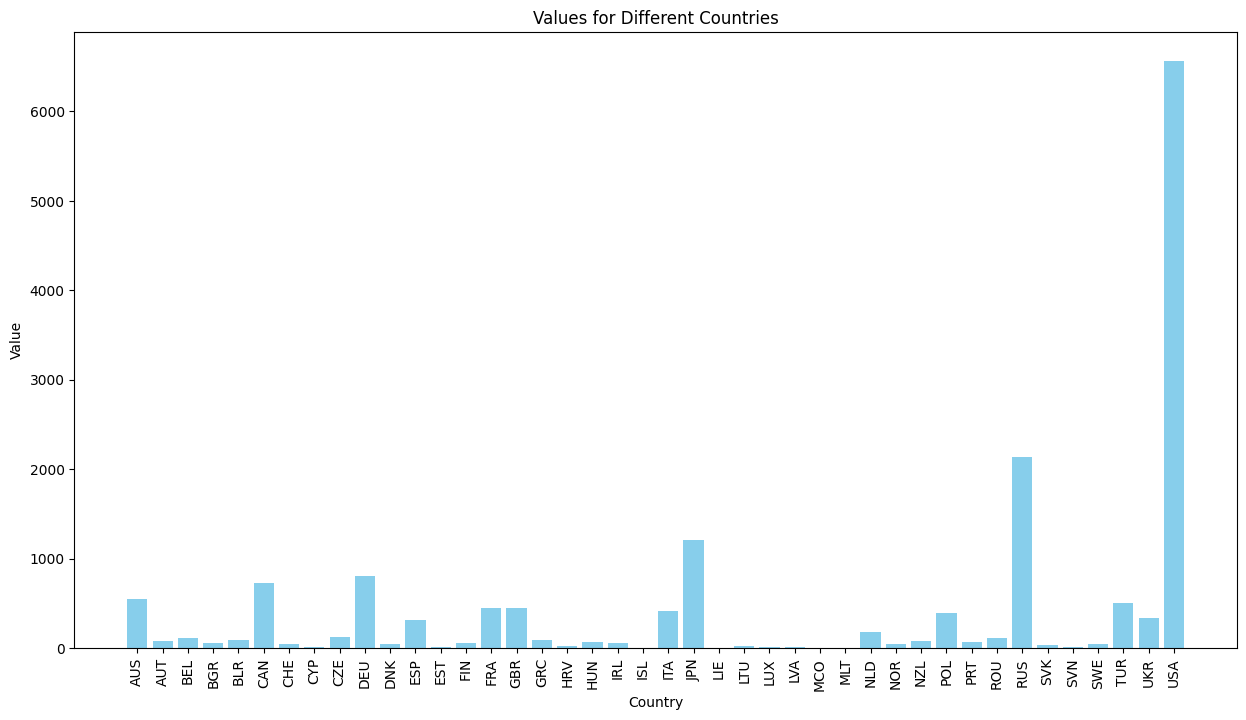

In [ ]:
import requests
import json
import requests

places_in_url = 'https://api.datacommons.org/node/places-in'
params = {
    'dcids': 'Earth',
    'placeType': 'Country',
}

# Making the GET request
response = requests.get(places_in_url, params=params)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Storing the response JSON data into the 'data' dictionary
    data = response.json()
else:
    print("Error:", response.status_code)

# Access the JSON string in the 'payload' key
json_string = data['payload']

# Convert JSON string to Python object
countries = json.loads(json_string)

# Extract 'place' values into a list and then just the country code
country_code_names = [country['place'].split('/')[-1] for country in countries]

# Now country_names contains all the country codes like 'ABW', etc.
print(country_code_names)

# API endpoint for fetching statistical data
url = 'https://api.datacommons.org/stat/value'


results = {}

for i, code in enumerate(country_code_names, 1):
    # Parameters for the API request
    params = {
        'place': f'country/{code}',
        'stat_var': 'sdg/EN_ATM_GHGT_AIP',
    }

    # Make the GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        results[code] = data
        print(f'[{i}/{len(country_code_names)}] Data fetched for {code}:', data)
    else:
        print(f'[{i}/{len(country_code_names)}] Failed to fetch data for {code}. Status code:', response.status_code)

# After the loop, results will contain the data fetched for each country code.
# Initialize an empty dictionary to store countries with their 'value'
country_values = {}

# Iterate through each item in the data list
for item in data:
    # Check if the 'value' key exists in the item's 'data'
    if 'value' in item['data']:
        # If so, store the country code as the key and the 'value' as its value
        country_values[item['country_code']] = item['data']['value']

country_values = {}

# Iterate through each item in the results dictionary
for code, result in results.items():
    # Check if the 'value' key exists in the result
    if 'value' in result:
        # If so, store the country code as the key and the 'value' as its value
        country_values[code] = result['value']

# Now, country_values will only contain those countries that have a 'value'
print(country_values)


import matplotlib.pyplot as plt

# Filter out the non-empty values
non_empty_values = {country: value for country, value in country_values.items() if value is not None}

# Extract countries and their corresponding values
countries = list(non_empty_values.keys())
values = list(non_empty_values.values())

# Create a bar plot
plt.figure(figsize=(15, 8))
plt.bar(countries, values, color='skyblue')
plt.xlabel('Country')
plt.ylabel('Value')
plt.title('Values for Different Countries')
plt.xticks(rotation=90)
plt.show()

# EU values for EN_ATM_GHGT_AIP

In [ ]:
# European Union is different, its not a 'Country' property but rather `GeoRegion` API endpoint for fetching statistical data
import requests
import json

# API endpoint for fetching statistical data

url = 'https://api.datacommons.org/stat/series'

# Special case for European Union
eu_params = {
    'place': 'undata-geo/G00500360',
    'stat_var': 'sdg/EN_ATM_GHGT_AIP',
}

# Make the GET request for the European Union
response = requests.get(url, params=eu_params)

if response.status_code == 200:
    eu_data = response.json()
    if 'value' in eu_data:
        # Add the European Union data to the results with a key indicating it's a georegion
        results['European Union'] = eu_data['value']
    print(f'Data fetched for European Union:', eu_data)
else:
    print(f'Failed to fetch data for European Union. Status code:', response.status_code)

# Initialize an empty dictionary to store countries and georegions with their 'value'
country_values = {}


# Now, country_values will contain countries and the European Union georegion that have a 'value'
print(country_values)

import matplotlib.pyplot as plt

# Filter out the non-empty values
non_empty_values = {place: value for place, value in country_values.items() if value is not None}

# Extract places and their corresponding values
places = list(non_empty_values.keys())
values = list(non_empty_values.values())

Data fetched for European Union: {'series': {'2006': 5214.7053, '2015': 4322.94126, '2000': 5154.15802, '1994': 5243.85388, '2005': 5225.91919, '2013': 4469.2877, '2011': 4625.10103, '2004': 5260.52407, '2009': 4674.52179, '1991': 5544.26459, '1997': 5310.09891, '1995': 5291.52412, '2010': 4778.99296, '1990': 5639.3767, '2001': 5205.01842, '1996': 5405.82404, '2007': 5164.33522, '1998': 5268.61521, '1993': 5272.78867, '2002': 5170.96466, '2017': 4315.84605, '2018': 4220.93223, '2016': 4300.89879, '2019': 4056.38934, '2008': 5046.19913, '2014': 4292.17659, '2003': 5259.18202, '2012': 4566.63514, '1992': 5371.20886, '1999': 5163.02208}}
{}


In [ ]:
import requests
import json
import csv

places_in_url = 'https://api.datacommons.org/node/places-in'
params = {
    'dcids': 'Earth',
    'placeType': 'Country',
}

# Making the GET request
response = requests.get(places_in_url, params=params)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Storing the response JSON data into the 'data' dictionary
    data = response.json()
else:
    print("Error:", response.status_code)

# Access the JSON string in the 'payload' key
json_string = data['payload']

# Convert JSON string to Python object
countries = json.loads(json_string)

# Extract 'place' values into a list and then just the country code
country_code_names = [country['place'].split('/')[-1] for country in countries]

# API endpoint for fetching statistical data
url = 'https://api.datacommons.org/stat/series'

# Initialize lists to store non-empty and empty countries
EN_ATM_GHGT_AIP_Countries = []
empty_countries = []

results = {}

for i, code in enumerate(country_code_names, 1):
    # Parameters for the API request
    params = {
        'place': f'country/{code}',
        'stat_var': 'sdg/EN_ATM_GHGT_AIP',
    }

    # Make the GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if 'series' in data:  # Ensure there is 'series' data before adding
            results[code] = data['series']
            EN_ATM_GHGT_AIP_Countries.append(code)  # Store non-empty country code
        else:
            empty_countries.append(code)  # Store empty country code
        print(f'[{i}/{len(country_code_names)}] Data fetched for {code}:', data)
    else:
        print(f'[{i}/{len(country_code_names)}] Failed to fetch data for {code}. Status code:', response.status_code)

# Initialize an empty dictionary to store countries with their series data
country_series = {}

# Iterate through each item in the results dictionary
for code, series_data in results.items():
    # Directly store the series data without needing to check for 'series' again
    country_series[code] = series_data

# Now, country_series will contain the series data for countries
print(country_series)


def save_and_describe_data(data, json_path, csv_path):
    """
    Saves the provided data to a JSON file and a CSV file.
    Prints the properties of the JSON object for each country.

    Args:
    - data: Dictionary containing the data to be saved.
    - json_path: Path where the JSON file will be saved.
    - csv_path: Path where the CSV file will be saved.
    """
    # Save the JSON file
    with open(json_path, "w") as json_file:
        json.dump(data, json_file, indent=4)

    # Save the CSV file
    with open(csv_path, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        # Write the header
        csv_writer.writerow(["Country", "Year", "Value"])
        # Write the data
        for country, series in data.items():
            for year, value in series.items():
                csv_writer.writerow([country, year, value])

    # Print properties of the JSON object for each country
    for country, series in data.items():
        properties = {
            "country": country,
            "number_of_years": len(series),
            "first_year": min(series.keys()),
            "last_year": max(series.keys()),
            "highest_emission": max(series.values()),
            "lowest_emission": min(series.values())
        }
        print(properties)

# Print non-empty and empty country lists
print("Country codes available for EN_ATM_GHGT_AIP:", EN_ATM_GHGT_AIP_Countries)
print("Empty countries:", empty_countries)


[1/256] Data fetched for ABW: {}
[2/256] Data fetched for AFG: {}
[3/256] Data fetched for AGO: {}
[4/256] Data fetched for AIA: {}
[5/256] Data fetched for ALA: {}
[6/256] Data fetched for ALB: {}
[7/256] Data fetched for AND: {}
[8/256] Data fetched for ANT: {}
[9/256] Data fetched for ARE: {}
[10/256] Data fetched for ARG: {}
[11/256] Data fetched for ARM: {}
[12/256] Data fetched for ASM: {}
[13/256] Data fetched for ATA: {}
[14/256] Data fetched for ATB: {}
[15/256] Data fetched for ATF: {}
[16/256] Data fetched for ATG: {}
[17/256] Data fetched for ATN: {}
[18/256] Data fetched for AUS: {'series': {'2008': 537.26231, '2018': 549.73194, '1996': 443.92827, '1994': 428.81822, '2007': 534.41784, '2003': 500.59996, '2009': 540.38162, '1992': 427.42608, '2015': 533.06383, '2001': 495.60431, '2004': 517.72651, '1993': 428.33707, '2019': 545.15252, '1998': 469.75152, '1990': 423.67222, '2017': 549.33002, '2014': 524.7094, '2011': 537.2055, '2010': 535.54922, '2006': 528.03842, '2005': 52

KeyboardInterrupt: 

In [6]:
import requests
import json
import csv

places_in_url = 'https://api.datacommons.org/node/places-in'
params = {
    'dcids': 'Earth',
    'placeType': 'Country',
}

# Making the GET request
response = requests.get(places_in_url, params=params)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Storing the response JSON data into the 'data' dictionary
    data = response.json()
else:
    print("Error:", response.status_code)

# Access the JSON string in the 'payload' key
json_string = data['payload']

# Convert JSON string to Python object
countries = json.loads(json_string)

# Extract 'place' values into a list and then just the country code
country_code_names = [country['place'].split('/')[-1] for country in countries]

In [ ]:
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# List derived from testing for series for the StatVar:
country_codes = [
    'AUS', 'AUT', 'BEL', 'BGR', 'BLR', 'CAN', 'CHE', 'CYP', 'CZE', 'DEU',
    'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL',
    'ISL', 'ITA', 'JPN', 'LIE', 'LTU', 'LUX', 'LVA', 'MCO', 'MLT', 'NLD',
    'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR',
    'UKR', 'USA'
]

url = 'https://api.datacommons.org/stat/series'
country_series = {}

for i, code in enumerate(country_codes, 1):
    params = {
        'place': f'country/{code}',
        'stat_var': 'sdg/EN_ATM_GHGT_AIP',
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Sort the series data by year before storing
        sorted_series = dict(sorted(data['series'].items(), key=lambda item: int(item[0])))
        country_series[code] = sorted_series
        print(f'[{i}/{len(country_codes)}] Data fetched for {code}: Sorted series')
    else:
        print(f'[{i}/{len(country_codes)}] Failed to fetch data for {code}. Status code:', response.status_code)


# Define the path for saving the JSON file
json_file_path = "country_series.json"

# Save the country_series data to a JSON file
with open(json_file_path, "w") as json_file:
    json.dump(country_series, json_file, indent=4)

def plot_graphs(selected_countries):
    plt.figure(figsize=(12, 6))
    for country in selected_countries:
        series = country_series[country]
        years = list(series.keys())
        values = list(series.values())
        plt.plot(years, values, label=country)
    plt.title('Line Graph for Selected Countries')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Adjusted to use SelectMultiple for multi-selection capability
countries_dropdown = widgets.SelectMultiple(
    options=country_codes,  # Assuming you want to list all countries for selection
    value=[country_codes[0]],  # Default selected country
    description='Countries:',
    disabled=False,
)

output = widgets.interactive_output(plot_graphs, {'selected_countries': countries_dropdown})

display(countries_dropdown, output)


[1/42] Data fetched for AUS: Sorted series
[2/42] Data fetched for AUT: Sorted series
[3/42] Data fetched for BEL: Sorted series
[4/42] Data fetched for BGR: Sorted series
[5/42] Data fetched for BLR: Sorted series
[6/42] Data fetched for CAN: Sorted series
[7/42] Data fetched for CHE: Sorted series
[8/42] Data fetched for CYP: Sorted series
[9/42] Data fetched for CZE: Sorted series
[10/42] Data fetched for DEU: Sorted series
[11/42] Data fetched for DNK: Sorted series
[12/42] Data fetched for ESP: Sorted series
[13/42] Data fetched for EST: Sorted series
[14/42] Data fetched for FIN: Sorted series
[15/42] Data fetched for FRA: Sorted series
[16/42] Data fetched for GBR: Sorted series
[17/42] Data fetched for GRC: Sorted series
[18/42] Data fetched for HRV: Sorted series
[19/42] Data fetched for HUN: Sorted series
[20/42] Data fetched for IRL: Sorted series
[21/42] Data fetched for ISL: Sorted series
[22/42] Data fetched for ITA: Sorted series
[23/42] Data fetched for JPN: Sorted seri

SelectMultiple(description='Countries:', index=(0,), options=('AUS', 'AUT', 'BEL', 'BGR', 'BLR', 'CAN', 'CHE',…

Output()

*Enhanced Insights into Global Greenhouse Gas Emissions*   
Feel free to edit anything(Clover)

In [7]:
import requests
import csv

# Define country codes including a special identifier for the European Union
country_codes = [
    'AUS', 'AUT', 'BEL', 'BGR', 'BLR', 'CAN', 'CHE', 'CYP', 'CZE', 'DEU',
    'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL',
    'ISL', 'ITA', 'JPN', 'LIE', 'LTU', 'LUX', 'LVA', 'MCO', 'MLT', 'NLD',
    'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR',
    'UKR', 'USA', 'European Union'  # Adding 'European Union' as a special case
]

url = 'https://api.datacommons.org/stat/series'

# Initialize a dictionary to store data
country_series_data = {}

for code in country_codes:
    if code == "European Union":
        params = {
            'place': 'europeanUnion',
            'stat_var': 'sdg/EN_ATM_GHGT_AIP',
        }
    else:
        params = {
            'place': f'country/{code}',
            'stat_var': 'sdg/EN_ATM_GHGT_AIP',
        }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if 'series' in data:
            country_series_data[code] = data['series']




In [ ]:
# Prepare data for CSV
csv_data = []

for country, series in country_series_data.items():
    values = list(series.values())
    average_emissions = sum(values) / len(values) if values else 0
    min_emissions = min(values) if values else 0
    max_emissions = max(values) if values else 0
    csv_data.append({
        "Country": country,
        "Average Emissions": average_emissions,
        "Min Emissions": min_emissions,
        "Max Emissions": max_emissions
    })


In [ ]:
csv_file_path = "emissions_data_analysis.csv"

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Country", "Average Emissions", "Min Emissions", "Max Emissions"])
    writer.writeheader()
    for row in csv_data:
        writer.writerow(row)

print("CSV file has been created successfully.")


In [ ]:
from google.colab import files

csv_file_path = 'emissions_data_analysis.csv'

files.download(csv_file_path)


In [ ]:
import pandas as pd

csv_file_path = 'emissions_data_analysis.csv'
df = pd.read_csv(csv_file_path)

print(df.head())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('emissions_data_analysis.csv')

plt.figure(figsize=(15, 10))
ax = sns.barplot(x='Average Emissions', y='Country', data=df.sort_values('Average Emissions', ascending=False))
plt.title('Average Greenhouse Gas Emissions by Country')
plt.xlabel('Average Emissions')
plt.ylabel('Country')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('emissions_data_analysis.csv')

plt.figure(figsize=(12, 8))


sns.kdeplot(data=df, x='Average Emissions', hue='Country', fill=True, common_norm=False)

plt.title('Density Plot of Greenhouse Gas Emissions by Country')
plt.xlabel('Average Emissions')
plt.ylabel('Density')


plt.show()

a timeline csv file with multiple years

In [ ]:
import pandas as pd
import requests



# Create an empty dictionary to store data for all countries for each year
all_data = {}


for code in country_codes:
    # API
    params = {
        'place': f'country/{code}',
        'stat_var': 'sdg/EN_ATM_GHGT_AIP',
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json().get('series', {})
        all_data[code] = data
    else:
        print(f"Failed to fetch data for {code}")

# Rebuild the data structure as a list, where each element of the list is a dictionary containing 'Country', 'Year' and 'Emission'.
records = []
for country, yearly_data in all_data.items():
    for year, emission in yearly_data.items():
        records.append({
            'Year': year,
            'Country': country,
            'Emission': emission
        })

# creat DataFrame
df = pd.DataFrame(records)


df['Year'] = pd.to_datetime(df['Year'])

# sort by year
df.sort_values(by='Year', inplace=True)

# save DataFrame as CSV
df.to_csv('complete_emissions_data.csv', index=False)


from google.colab import files
files.download('complete_emissions_data.csv')


In [ ]:
!pip install datacommons_pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()


In [ ]:
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


In [ ]:
import pandas as pd

# Make sure the filename matches the uploaded file's name
df = pd.read_csv('state_co2_emissions_from_fossil_fuel_combustion_1990-2018.csv')


2024/04/01